# Data Analysis
Analysis of line scans taken at the beam. See the `README` in the `Experimental Data` folder.

In [1]:
import utils
from importlib import reload

from sklearn.ensemble import RandomForestRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.metrics import *

from scipy.interpolate import interp1d
from scipy.optimize import basinhopping

utils = reload(utils)
from utils import *

## Load Reference Data

In [2]:
exp = parse_file('Reference Data/As_exp_standards_normalized.dat')
sim = parse_file('Reference Data/As_edge_sim_standards_phases_normalized.dat')

energy = np.array(sim['X1'], dtype=float)

sim_data_columns = [colm for colm in sim.columns if len(colm.replace('X', '')) > 3]
Sim_Refs = np.array(sim[sim_data_columns], dtype=float).T

exp_data_columns = [colm for colm in exp.columns if len(colm.replace('X', '')) > 3]
Exp_Refs = np.array(exp[exp_data_columns], dtype=float).T

refs = np.concatenate((Sim_Refs, Exp_Refs), axis=0)

Energy = np.linspace(11863, 11915, 5201)
Energy_exp = np.array([11866.5, 11870., 11873.5, 11876.5, 11879., 11885.5, 11900., 11904., 11909.5])

interperlator = interp1d(energy, refs)

Refs = interperlator(Energy)
Refs_exp = interperlator(Energy_exp)

print(f"Resolution: {Energy[1] - Energy[0]}")

data_columns = sim_data_columns + exp_data_columns

Resolution: 0.010000000000218279


### Visualize References

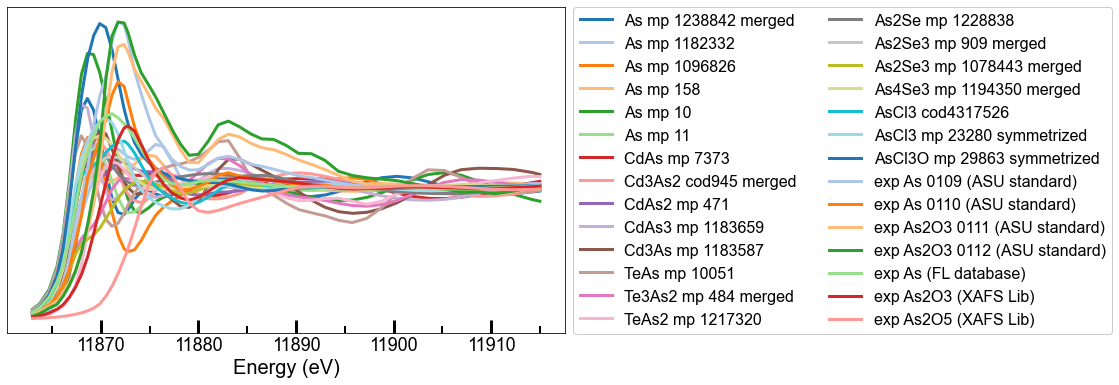

In [3]:
fig, ax = plt.subplots(figsize=(10, 6))
for i, ref in enumerate(Refs):
    if i >= 20:
        c = i - 20
    else:
        c = i
    label = f'{data_columns[i]}'
    ax.plot(Energy, ref, '-', linewidth=3, c=plt.cm.tab20(c/19), label=label, alpha=1.)
ax.legend(fontsize=16, loc='center left', bbox_to_anchor=(1., .5), ncol=2, framealpha=1.)
format_axis(ax, ticks=(5,10))
plt.show()

## Analyze references taken at beam

In [4]:
standard_fnames = ['lineAs_metal_scan006.mda.csv', 'lineCd3As2_scan008.mda.csv',
                   'lineAs2O3_scan009.mda.csv', 'lineAs3Te2_scan011.mda.csv']
standards = ['As metal', '$Cd_3As_2$', '$As_2O_3$', '$As_3Te_2$']
dfs = [pd.read_csv(f'Experimental data/Arsenic standards/{filename}') for filename in standard_fnames]
dfs = [preprocess_df(df) for df in dfs]

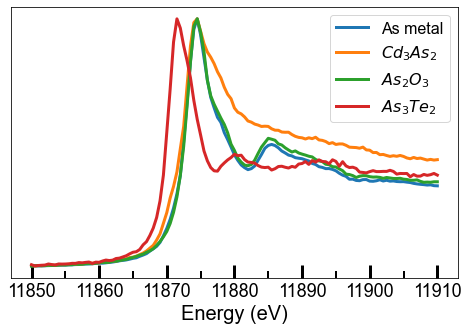

In [5]:
fig, ax = plt.subplots(figsize=(8, 5))

for i, label in enumerate(standards):
    x, y = get_xy_from_colms(dfs[i], 'Energy (keV)', 'I_0 (a.u.)')
    ax.plot(x, y, '-', linewidth=3, c=plt.cm.tab20(i*2), label=label)

ax.legend(fontsize=16, loc='upper right')
format_axis(ax, ticks=(5,10))
plt.show()

2.7399999999997817


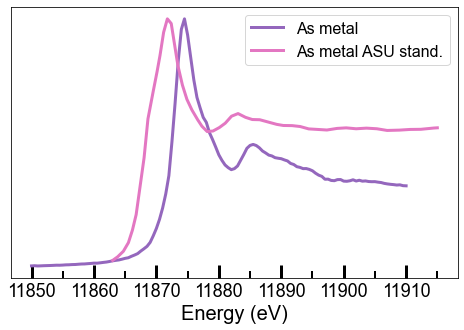

In [6]:
fig, ax = plt.subplots(figsize=(8, 5))

x1, y1 = get_xy_from_colms(dfs[0], 'Energy (keV)', 'I_0 (a.u.)')
ax.plot(x1, y1, '-', linewidth=3, c=plt.cm.tab20(8), label=standards[0])

x2 = Energy
y2 = Refs[22]
y2 = y2 / np.max(y2)
label = 'As metal ASU stand.'

delta_E = x1[np.argmax(y1)] - x2[np.argmax(y2)]
print(delta_E)

ax.plot(x2, y2, '-', linewidth=3, c=plt.cm.tab20(12), label=label)

ax.legend(fontsize=16, loc='upper right')
format_axis(ax, ticks=(5,10))
plt.show()

5.25


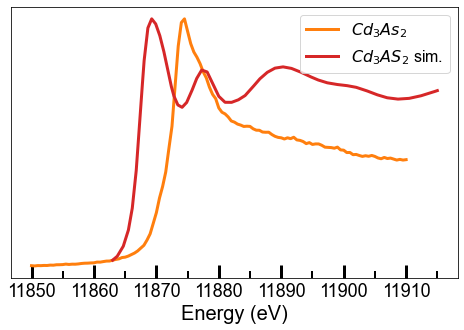

In [7]:
fig, ax = plt.subplots(figsize=(8, 5))

x1, y1 = get_xy_from_colms(dfs[1], 'Energy (keV)', 'I_0 (a.u.)')
ax.plot(x1, y1, '-', linewidth=3, c=plt.cm.tab20(2), label=standards[1])

x2 = Energy
y2 = Refs[7]
y2 = y2 / np.max(y2)
label = '$Cd_3AS_2$ sim.'

delta_E = x1[np.argmax(y1)] - x2[np.argmax(y2)]
print(delta_E)

ax.plot(x2, y2, '-', linewidth=3, c=plt.cm.tab20(6), label=label)

ax.legend(fontsize=16, loc='upper right')
format_axis(ax, ticks=(5,10))
plt.show()

2.7399999999997817


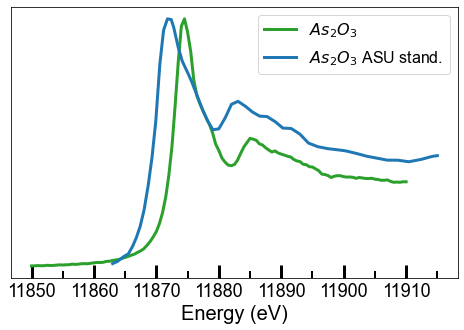

In [8]:
fig, ax = plt.subplots(figsize=(8, 5))

x1, y1 = get_xy_from_colms(dfs[2], 'Energy (keV)', 'I_0 (a.u.)')
ax.plot(x1, y1, '-', linewidth=3, c=plt.cm.tab20(4), label=standards[2])

x2 = Energy
y2 = Refs[24]
y2 = y2 / np.max(y2)
label = '$As_2O_3$ ASU stand.'

delta_E = x1[np.argmax(y1)] - x2[np.argmax(y2)]
print(delta_E)

ax.plot(x2, y2, '-', linewidth=3, c=plt.cm.tab20(0), label=label)

ax.legend(fontsize=16, loc='upper right')
format_axis(ax, ticks=(5,10))
plt.show()

## Energy shift
A 2.73 eV energy shift will be applied to all simulated references so that is is aligned with the new experimental data.

In [9]:
def spectral_loss(x, spectrum, target, metric):
    return eval(metric)(x*spectrum, target)

def get_scale(spectrum, target, metric='mean_absolute_error'):
    alpha0 = 0.1
    alpha = minimize(spectral_loss, alpha0, args=(spectrum, target, metric))['x']
    return alpha

In [10]:
exp_energy = np.array(dfs[0]['Energy (keV)'], dtype=float)
print(min(exp_energy)*1000, max(exp_energy)*1000)
print(min(energy) + 2.74, max(energy) + 2.74)

11850.0 11910.0
11859.356 11930.764


In [11]:
energy = energy + 2.74

bool_arr = exp_energy*1000 > 11865
Exp_Energy = exp_energy[bool_arr]*1000
Energy = Exp_Energy.copy()

interperlator = interp1d(energy, refs)

Refs = interperlator(Energy)

0.0
[0.39389444]


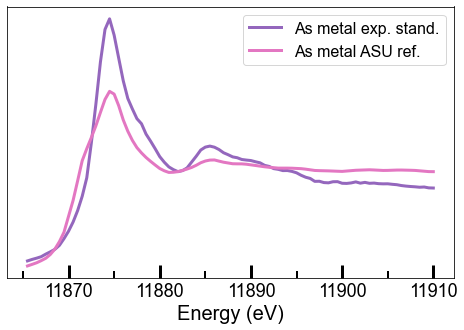

In [12]:
fig, ax = plt.subplots(figsize=(8, 5))

x1, y1 = get_xy_from_colms(dfs[0], 'Energy (keV)', 'I_0 (a.u.)')
x1 = x1[bool_arr]
y1 = y1[bool_arr]
label = standards[0] + ' exp. stand.'
ax.plot(x1, y1, '-', linewidth=3, c=plt.cm.tab20(8), label=label)

x2 = Energy
y2 = Refs[22]
#y2 = y2 / np.max(y2)
label = 'As metal ASU ref.'

delta_E = x1[np.argmax(y1)] - x2[np.argmax(y2)]
print(delta_E)

alpha = get_scale(y2, y1)
print(alpha)
y2 = alpha*y2

ax.plot(x2, y2, '-', linewidth=3, c=plt.cm.tab20(12), label=label)

ax.legend(fontsize=16, loc='upper right')
format_axis(ax, ticks=(5,10))
plt.savefig('Figures/As_metal_exp_comparison.png', dpi=800, transparent=True)

0.0
[0.33828219]


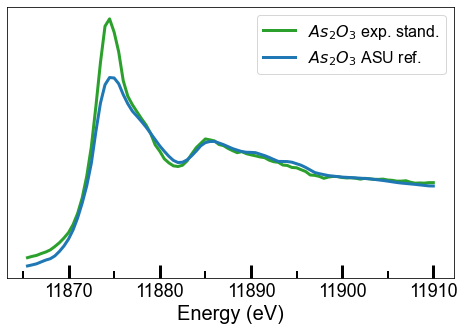

In [13]:
fig, ax = plt.subplots(figsize=(8, 5))

x1, y1 = get_xy_from_colms(dfs[2], 'Energy (keV)', 'I_0 (a.u.)')
x1 = x1[bool_arr]
y1 = y1[bool_arr]
label = standards[2] + ' exp. stand.'
ax.plot(x1, y1, '-', linewidth=3, c=plt.cm.tab20(4), label=label)

x2 = Energy
y2 = Refs[24]
#y2 = y2 / np.max(y2)
label = '$As_2O_3$ ASU ref.'

delta_E = x1[np.argmax(y1)] - x2[np.argmax(y2)]
print(delta_E)

alpha = get_scale(y2, y1)
print(alpha)
y2 = alpha*y2

ax.plot(x2, y2, '-', linewidth=3, c=plt.cm.tab20(0), label=label)

ax.legend(fontsize=16, loc='upper right')
format_axis(ax, ticks=(5,10))
plt.savefig('Figures/As2O3_exp_comparison.png', dpi=800, transparent=True)

References after energy shift and scaling

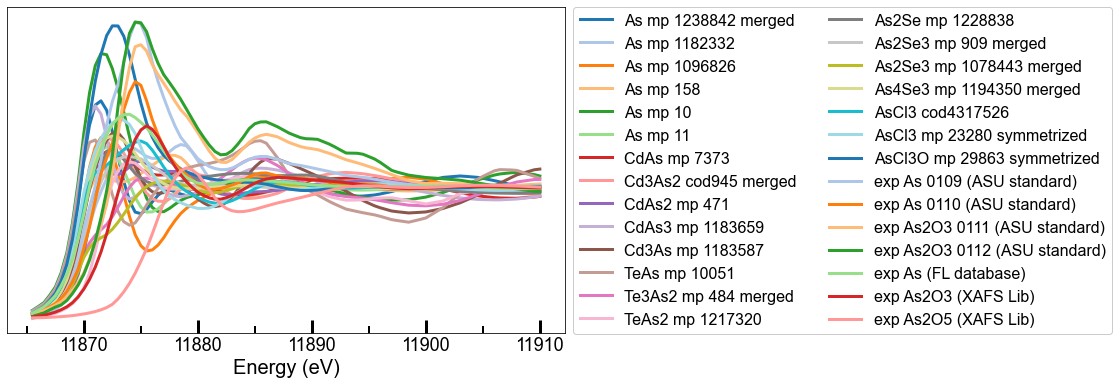

In [14]:
fig, ax = plt.subplots(figsize=(10, 6))
for i, ref in enumerate(Refs):
    if i >= 20:
        c = i - 20
    else:
        c = i
    label = f'{data_columns[i]}'
    ax.plot(Energy, ref * alpha, '-', linewidth=3, c=plt.cm.tab20(c/19), label=label, alpha=1.)
ax.legend(fontsize=16, loc='center left', bbox_to_anchor=(1., .5), ncol=2, framealpha=1.)
format_axis(ax, ticks=(5,10))
plt.show()

# Visualize the Experimental Data

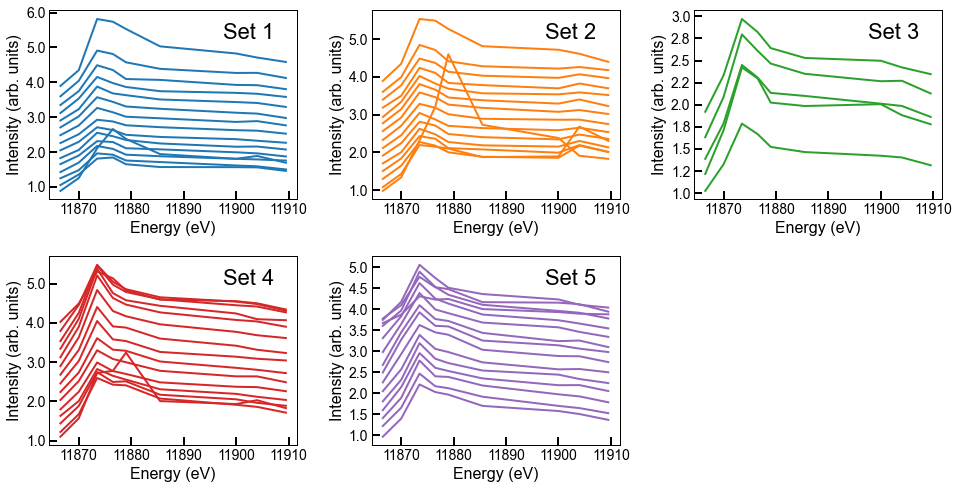

In [15]:
Energies = np.array([11.8665, 11.87, 11.8735, 11.8765, 11.879,
                     11.8855, 11.9, 11.904, 11.9095])
DATA = get_all_data(Energies)
# data is a list (by set) of a list (by pixel number) of dictaries (by xy pos)

nrows = 2
ncols = 3
fig, axes = plt.subplots(figsize=(16, 8), nrows=nrows, ncols=ncols)
plt.subplots_adjust(wspace=0.3, hspace=0.3)

for Set in range(1, 7):
    row = (Set - 1) // ncols
    colm = (Set - 1) % ncols
    ax = axes[row, colm]
    if Set <= 5:
        setdata = DATA[Set] 
        for i, pt in enumerate(setdata):
            intensity = np.array(pt['I'], dtype=float)
            ax.plot(pt['E'], intensity / 1000 + i*0.2, '-', linewidth=2, c=plt.cm.tab10(Set - 1))
    
        ax.annotate(f'Set {Set}', (0.7, 0.85), xycoords='axes fraction', fontsize=22)
        ax.set_ylabel("Intensity (arb. units)", fontsize=16)        
        ax.set_xlabel("Energy (eV)", fontsize=16)
        ax.tick_params(direction='in', width=2, length=8, which='major', axis='both')
        ax.set_xticklabels(np.array(ax.get_xticks(), dtype=int), fontsize=14)
        ax.set_yticklabels(np.array(ax.get_yticks(), dtype=float), fontsize=14)
        ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
        set_spine_width(ax, width=1.)
    else:
        ax.axis('off')

#plt.savefig('Figures/linescans.png', dpi=800, transparent=True)

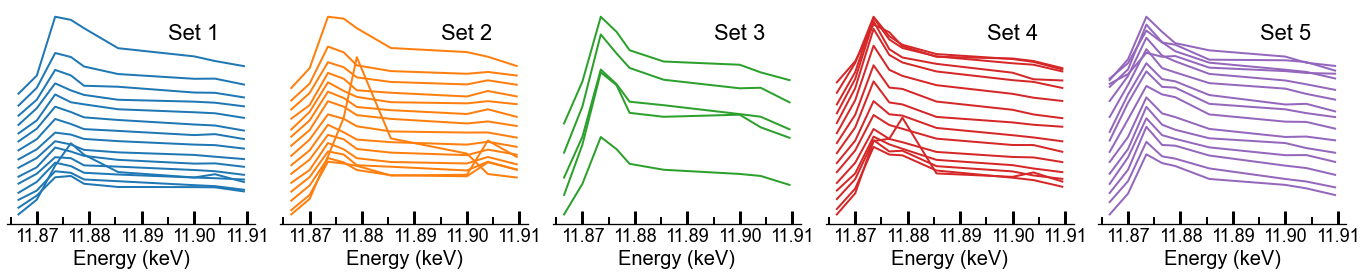

In [16]:
ncols = 5
fig, axes = plt.subplots(figsize=(24, 4), nrows=1, ncols=ncols)
plt.subplots_adjust(wspace=0.1, hspace=0.)

for Set in range(1, 6):
    colm = (Set - 1) % ncols
    ax = axes[colm]
    
    setdata = DATA[Set] 
    for i, pt in enumerate(setdata):
        intensity = np.array(pt['I'], dtype=float)
        ax.plot(np.array(pt['E']) / 1000, intensity / 1000 + i*0.2, '-', linewidth=2, c=plt.cm.tab10(Set - 1))
    
    ax.annotate(f'Set {Set}', (0.65, 0.85), xycoords='axes fraction', fontsize=22)
    
    ax.set_yticks([])
    ax.set_xlabel('Energy (keV)', fontsize=20)
    ax.xaxis.set_minor_locator(MultipleLocator(0.005))
    ax.xaxis.set_major_locator(MultipleLocator(0.010))
    ax.set_xticklabels(np.array(ax.get_xticks(), dtype=float), fontsize=18)
    ax.tick_params(direction='in', width=3, length=13, which='major')
    ax.tick_params(direction='in', width=2, length=7, which='minor')
    ax.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    set_spine_width(ax, width=1.3)
    turn_off_spines(ax, spines=['top', 'left', 'right'])

plt.savefig('Figures/linescans_smushed.png', dpi=800, transparent=True, bbox_inches='tight', )

# Minimization of a reconstruction loss

In [17]:
n = len(refs)
coeffs = get_coeffs(n, 0.9)
#print(coeffs)
d = refs.T @ coeffs
min(coeffs), min(d)

(0.0, -0.002489853298129495)

In [18]:
X = Energies * 1000
interperlator = interp1d(energy, refs)
Y_Refs = interperlator(X)

In [19]:
kwargs = {'N': 5, 'scale': 0.0, 'dropout': 0.9, 'training': False}
test_data, test_coeffs = generate_linear_combos(Y_Refs, **kwargs)

In [20]:
utils = reload(utils)
from utils import *

In [23]:
tol = 0.05
unscaled_coeffs = get_coeffs_from_spectra(test_data, Y_Refs, scaling=False, tol=tol)
scale, scaled_coeffs = get_coeffs_from_spectra(test_data, Y_Refs, scaling=True, tol=tol)

In [24]:
scaled_coeffs[0]

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.1014282 , 0.08856114,
       0.13065507, 0.15920531, 0.10895906, 0.09147201, 0.10641847,
       0.11407837, 0.09922237, 0.        ])

mean absolute error: 0.0
mean absolute error: 0.04064661895947346
mean absolute error: 0.24040758994005745


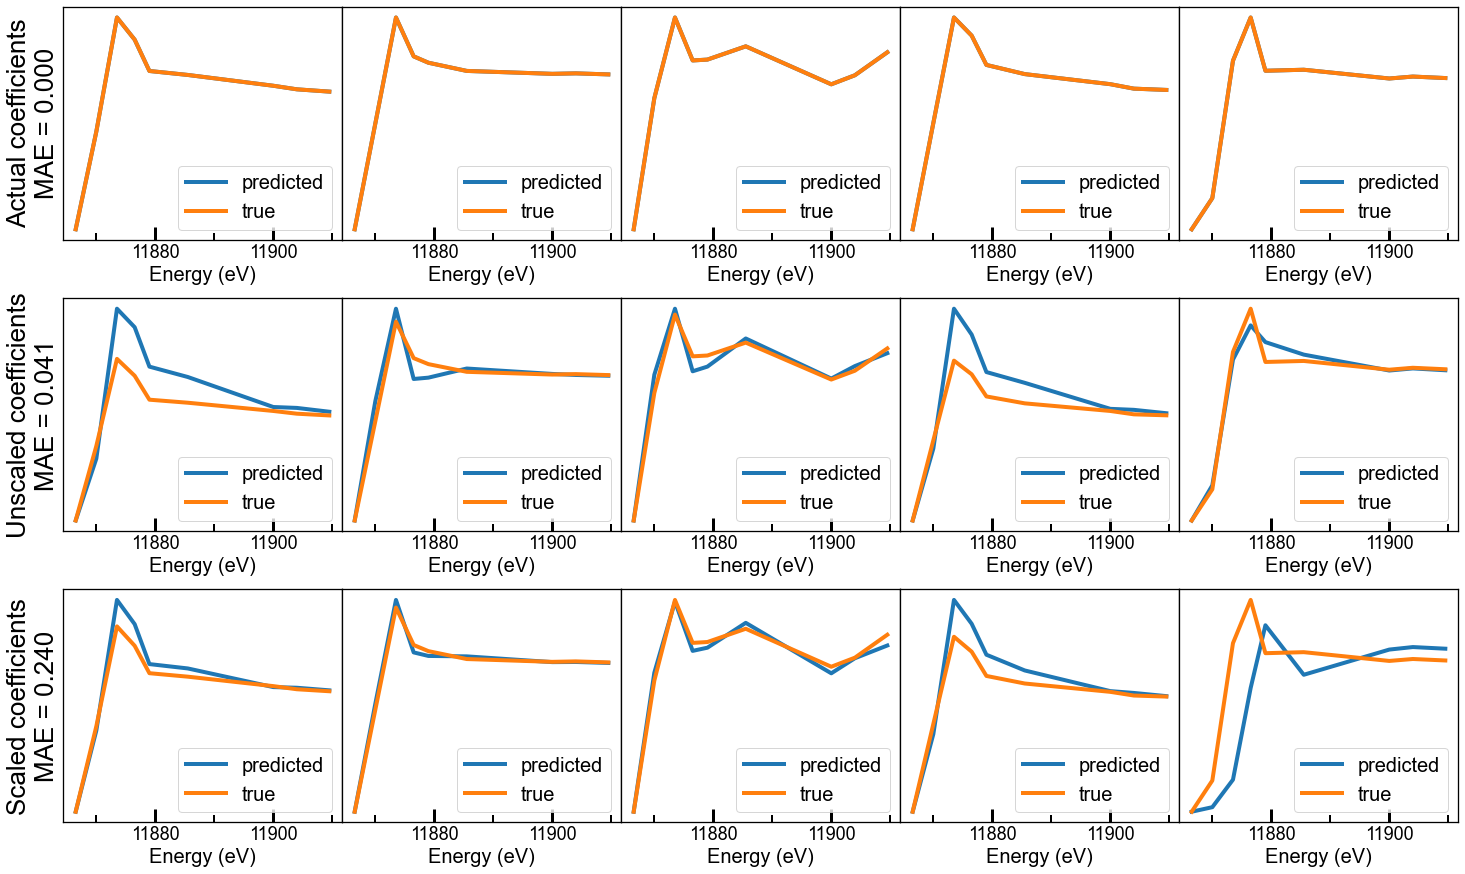

In [25]:
m = 5
fig, axes = plt.subplots(figsize=(5*m, 5*3), ncols=m, nrows=3)
plt.subplots_adjust(wspace=0, hspace=0.25)

true_error = plot_reconstructions((fig, axes[0, :]), test_data, test_coeffs, m, X, Y_Refs)
unscaled_error = plot_reconstructions((fig, axes[1, :]), test_data, unscaled_coeffs, m, X, Y_Refs)
scaled_error = plot_reconstructions((fig, axes[2, :]), test_data, scaled_coeffs, m, X, Y_Refs, scale=scale)

axes[0, 0].set_ylabel(f'Actual coefficients\nMAE = {true_error:.3f}', fontsize=26)
axes[1, 0].set_ylabel(f'Unscaled coefficients\nMAE = {unscaled_error:.3f}', fontsize=26)
axes[2, 0].set_ylabel(f'Scaled coefficients\nMAE = {scaled_error:.3f}', fontsize=26)

for i in range(axes.shape[0]):
    for j in range(axes.shape[1]):
        set_spine_width(axes[i, j], width=1.3) 

plt.savefig(f'Figures/true_vs_unscaled_vs_scaled_recon_spectra_plots_tol_{tol}.png', dpi=800,
            bbox_inches='tight', transparent=True)

In [26]:
def get_label_and_color(column_name):
    ele_to_idx_map = {'Cd': 2, 'Te': 8, 'Se': 6, 'Cl': 4, 'exp': 1, 'As': 0}

    for key in ele_to_idx_map.keys():
        if key in column_name:
            c = ele_to_idx_map[key]
            if key == 'exp':
                label = column_name.replace('exp ', '*').replace('standard', 'ref.')
            else:
                label = column_name.replace('merged', '').replace('symmetrized', '').replace('mp ', '')
            break
    return label, c

In [45]:
def make_conc_bar_chart(plot, coeffs, data_columns, width=0.5, ncol=2, compress_colors=True):
    
    m = coeffs.shape[0]
    fig, ax = plot
    labels = ["$" + "P_{" + f"{i}" + "}$" for i in range(1, m + 1)]
   
    c = 0
    idxs = []
    for i in range(coeffs.shape[1]):
        if coeffs[:, i].any() > 0:
            label, color = get_label_and_color(data_columns[i])
            if not compress_colors:
                color = i%20
            if c == 0:
                ax.bar(labels, coeffs[:, i]*100, width, label=label,
                       fc=plt.cm.tab20(color))
            else:
                bottoms = np.sum([coeffs[:, k]*100 for k in idxs], axis=0)
                ax.bar(labels, coeffs[:, i]*100, width, label=label,
                       fc=plt.cm.tab20(color), bottom=bottoms)
            c += 1
            idxs.append(i)

    plt.legend(fontsize=18, bbox_to_anchor=(1., 0.5), loc='center left', ncol=ncol)

    ax.tick_params(direction='out', width=2, length=10, which='major', axis='both')
    ax.set_ylabel('Concentration (%)', fontsize=20)
    ax.set_yticklabels(np.array(ax.get_yticks(), dtype=int), fontsize=18)
    ax.set_xticklabels(labels, fontsize=20)

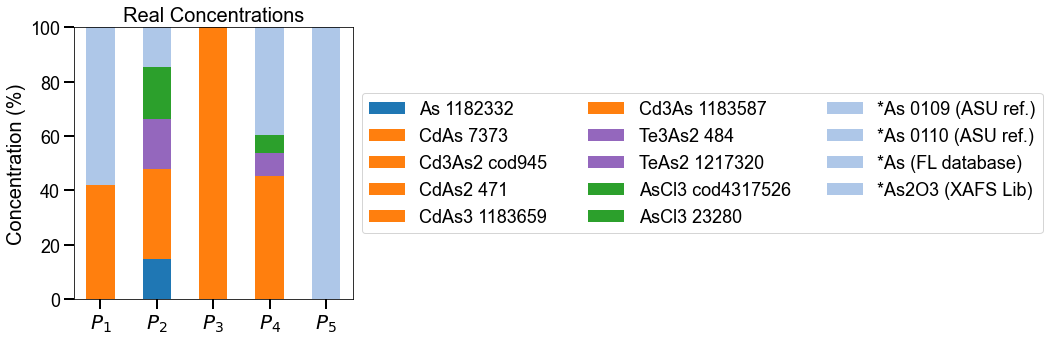

In [46]:
fig, ax = plt.subplots(figsize=(5, 5), ncols=1)
plt.subplots_adjust(wspace=0, hspace=0.25)
make_conc_bar_chart((fig, ax), test_coeffs, data_columns, ncol=3)
plt.title('Real Concentrations', fontsize=20)
plt.savefig('Figures/real_coeff_bar_chart.png', dpi=800, bbox_inches='tight', transparent=True)

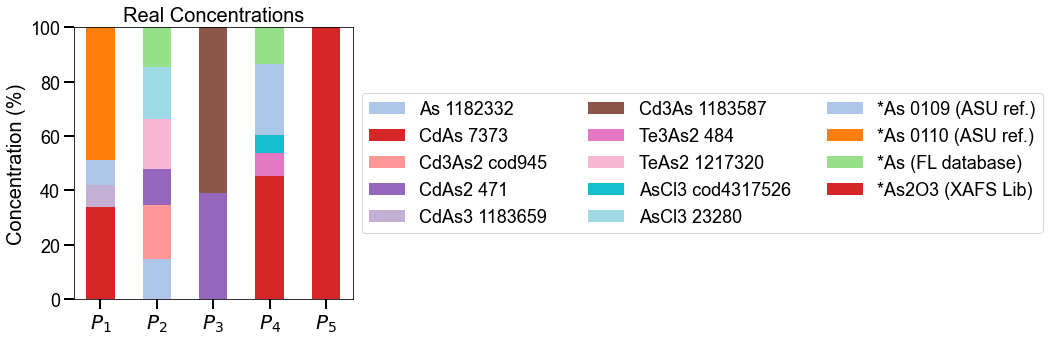

In [48]:
fig, ax = plt.subplots(figsize=(5, 5), ncols=1)
plt.subplots_adjust(wspace=0, hspace=0.25)
make_conc_bar_chart((fig, ax), test_coeffs, data_columns, ncol=3, compress_colors=False)
plt.title('Real Concentrations', fontsize=20)
plt.show()

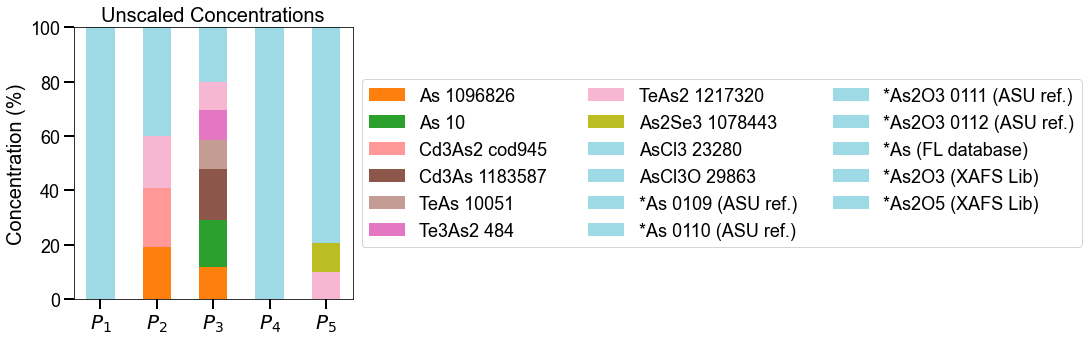

In [35]:
fig, ax = plt.subplots(figsize=(5, 5), ncols=1)
plt.subplots_adjust(wspace=0, hspace=0.25)
make_conc_bar_chart((fig, ax), unscaled_coeffs, data_columns, ncol=3)
plt.title('Unscaled Concentrations', fontsize=20)
plt.savefig(f'Figures/unscaled_coeff_bar_chart_tol_{tol}.png', dpi=800,
            bbox_inches='tight', transparent=True)

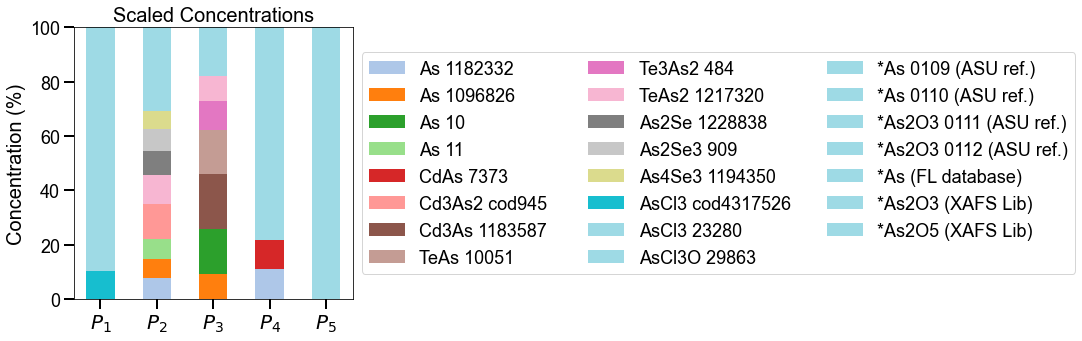

In [36]:
fig, ax = plt.subplots(figsize=(5, 5), ncols=1)
plt.subplots_adjust(wspace=0, hspace=0.25)
make_conc_bar_chart((fig, ax), scaled_coeffs, data_columns, ncol=3)
plt.title('Scaled Concentrations', fontsize=20)
plt.savefig(f'Figures/scaled_coeff_bar_chart_tol_{tol}.png', dpi=800,
            bbox_inches='tight', transparent=True)

In [105]:
def get_error(coeffs, target, Refs, scale,
              metric='mean_absolute_error'):
    pred_spectrum = Refs.T @ coeffs
    pred_spectrum = pred_spectrum * scale
    pred_spectrum = pred_spectrum - np.min(pred_spectrum)
    targte = target - np.min(target)
    return eval(metric)(pred_spectrum, target)

In [106]:
def get_errors_with_different_noises(Y_Refs, noises=np.arange(0, 0.06, 0.01),
                                     metric='mean_absolute_error'):
    """Return spectral recon error given minimization process for scaled vs unscaled spectra."""
    Errors = []
    for scale in noises:
        print(f'Noise: {scale * 100}%')

        N = 50
        kwargs = {'N': N, 'scale': scale, 'dropout': 0.9, 'training': False}
        test_data, test_coeffs = generate_linear_combos(Y_Refs, **kwargs)

        unscaled_coeffs = get_coeffs_from_spectra(test_data, Y_Refs, scaling=False)
        scales, scaled_coeffs = get_coeffs_from_spectra(test_data, Y_Refs, scaling=True)

        errors = [[], [], []]
        i = 0
        for coeffs, scale in zip([test_coeffs, unscaled_coeffs, scaled_coeffs],
                                 [np.ones(N),  np.ones(N),      scales]):
            for j in range(N):
                error = get_error(coeffs[j], test_data[j], Y_Refs, scale[j], metric=metric)
                errors[i].append(error)
            i += 1
        Errors.append(errors)
    return np.array(Errors)

In [107]:
Errors = get_errors_with_different_noises(Y_Refs)

Noise: 0.0%
Noise: 1.0%
Noise: 2.0%
Noise: 3.0%
Noise: 4.0%
Noise: 5.0%


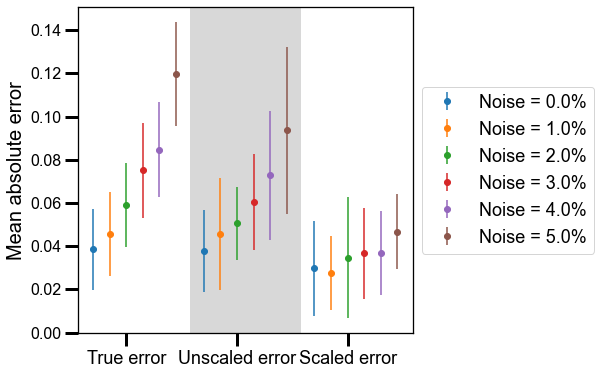

In [108]:
fig, ax = plt.subplots(figsize=(6, 6))

labels = ['True error', 'Unscaled error', 'Scaled error']
noises = np.arange(0, 0.06, 0.01)
ax.axvspan(0.875, 1.875, fc=plt.cm.tab10(7), alpha=0.3)

for i, noise in enumerate(noises):
    errors = Errors[i]
    for j in range(errors.shape[0]):
        err = errors[j, :]
        if j == 0:
            label = f"Noise = {noise * 100}%"
        else:
            label = None
        #print(j + i*0.15)
        plt.errorbar(np.array([j]) + i*0.15, np.average(err), yerr=np.std(err), fmt='o',
                     color=plt.cm.tab10(i), label=label)
        
plt.legend(fontsize=18, bbox_to_anchor=(1., 0.5), loc='center left')

ax.tick_params(direction='out', width=3, length=13, which='major', axis='both')

ax.set_ylabel('Mean absolute error', fontsize=20)
ax.set_yticklabels(np.array(ax.get_yticks(), dtype=float), fontsize=16)

x_pos = np.array([i + 0.3 for i, _ in enumerate(labels)])
ax.set_xticklabels(np.array(ax.get_xticks(), dtype=float), fontsize=16)
plt.xticks(x_pos, labels, fontsize=18)

ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
set_spine_width(ax, width=1.3)

plt.savefig('Figures/minimization_optimization_noise_error.png', dpi=800,
            bbox_inches='tight', transparent=True)

# Find coeffs of experimental data using minimimzation with scaling

Set 1
Getting coeffs...
Setting up bar chart...
Set 2
Getting coeffs...
Setting up bar chart...
Set 3
Getting coeffs...
Setting up bar chart...
Set 4
Getting coeffs...
Setting up bar chart...
Set 5
Getting coeffs...
Setting up bar chart...


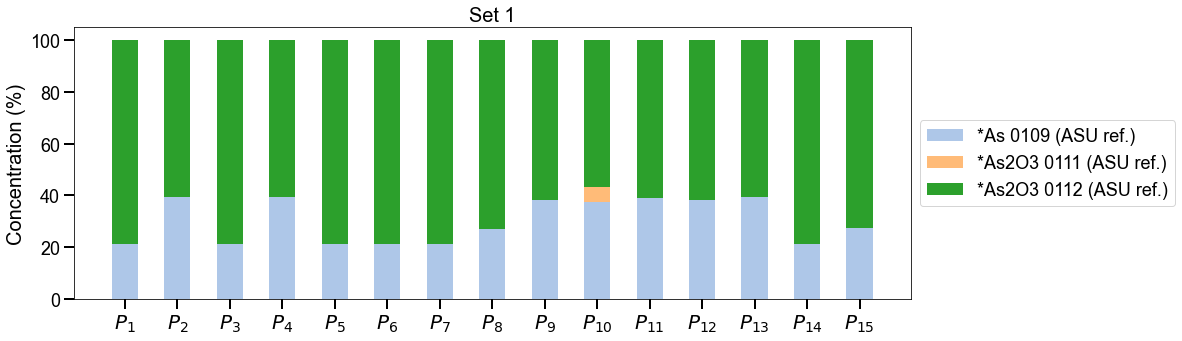

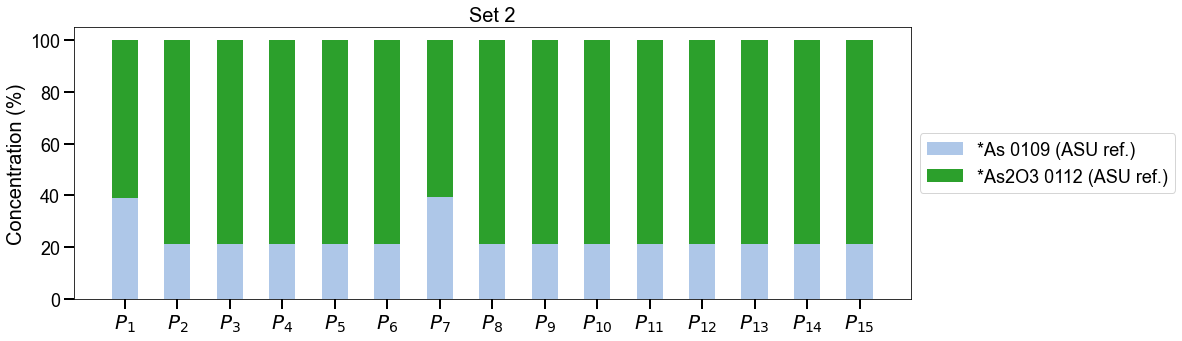

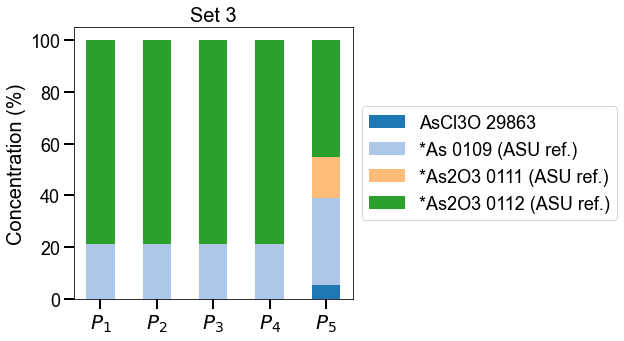

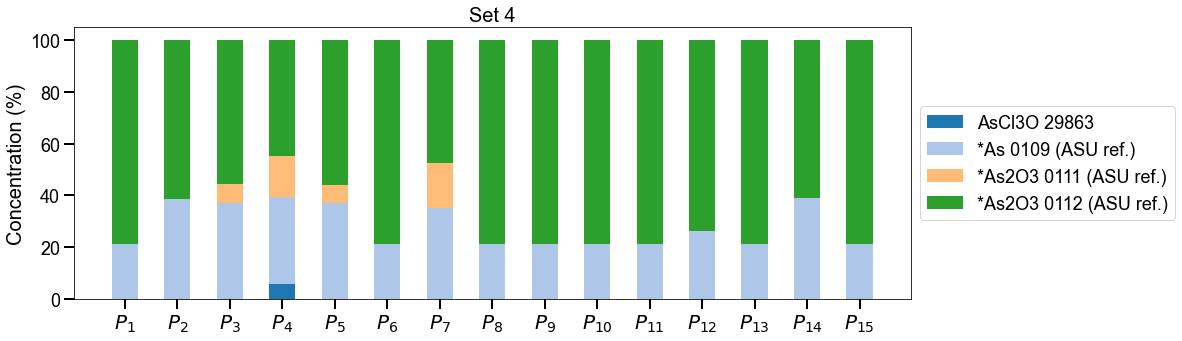

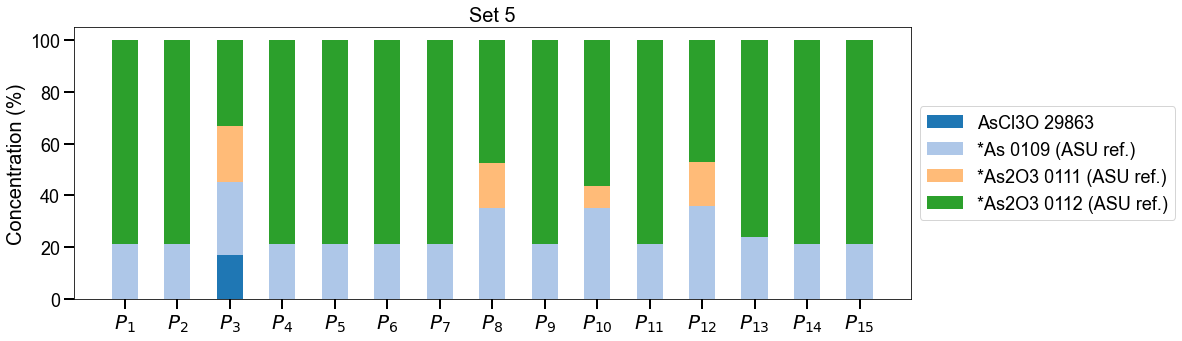

In [49]:
for Set in range(1, 6):
    print(f'Set {Set}')
    setdata = DATA[Set]
    Spectra = []
    for i, pt in enumerate(setdata):
        spectrum = np.array(pt['I'], dtype=float)
        Spectra.append(spectrum)
    print('Getting coeffs...')
    Scales, Coeffs = get_coeffs_from_spectra(np.array(Spectra), Y_Refs, scaling=True, tol=0.05)
    print('Setting up bar chart...')
    
    fig, ax = plt.subplots(figsize=(len(setdata), 5), ncols=1)
    plt.subplots_adjust(wspace=0, hspace=0.25)
    
    make_conc_bar_chart((fig, ax), Coeffs, data_columns, ncol=1, compress_colors=False)
    
    plt.title(f'Set {Set}', fontsize=20)
    plt.savefig(f'Figures/Set_{Set}_coeff_bar_chart.png', dpi=800, transparent=True)

# Supervised Machine Learning
Train a model to correlate dataset of linear combinations of the selected energies to the coefficients of the components.

In [16]:
kwargs = {'N': 500, 'scale': 0.03, 'dropout': 0.9, 'training': False}
data, coeffs = generate_linear_combos(Refs, **kwargs)
kwargs = {'N': 50, 'scale': 0.03, 'dropout': 0.9, 'training': False}
test_data, test_coeffs = generate_linear_combos(Refs, **kwargs)